# Mapping Murdock's Ethnographic Atlas
## using geopandas and ipyleaflet )

This notebook illustrates how to do mapping and some geospatial analysis using various python libraries.  All of this can of course be done inside of dedicated GIS client such as QGIS or ARCGIS but for easier replication, documentation and/or automation there are advantages to putting code in one place. 

The notebook illustrates how to load and display vector polygon geospatial data using the powerful [geopandas](https://github.com/geopandas/geopandas). We'll also use [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) to create 'slippy' and interactive maps.


Broad outline:

1. load vector polygon from [Morduck's Ethnographic Atlas](http://devecondata.blogspot.com/2007/10/ethnographic-atlas.html)  data digitized by Nathan Nunn. We'll display the data and show how to also plot markers on a different map layer.

2. Load and display gridded raster data on wheat suitability. 

3. Calculate raster zonal statistics 

4. (not finished) Discuss how data such as that constructed in step 3 was used in an empirical paper by James Fenske...

In [1]:
import pandas as pd
import geopandas as gpd
import ipyleaflet as ilf
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
plt.style.use('bmh')

#### Morduck's Ethnographic Atlas
Shapefile [digitized by Nathan Nunn](https://scholar.harvard.edu/nunn/pages/data-0).  A 'shapefile' is a widely used ARCGIS format to store vector polygon data.  It's not just one file but several files that are often shipped together in a compressed zip file. Geopandas has a method to open these directly from the zip file.   We import this shapefile into a geopandas dataframe and inspect the first 3 rows:

In [2]:
shpfile = r'zip://borders_tribes.zip'
tribe_areas = gpd.GeoDataFrame.from_file(shpfile)
tribe_areas.head(3)

,NAME,TRIBE_CODE,LAT,LON,geometry
0,ABABDA,1,23.161800,33.70160,"POLYGON ((35.73971 22.87611, 35.54412 22.64326..."
1,ABARAMBO,2,3.702955,26.79730,"POLYGON ((26.45080 3.39284, 26.45227 3.39798, ..."
2,ABE,3,6.069531,-4.26032,"POLYGON ((-4.07477 6.37522, -4.01895 6.26358, ..."


Among many other things geopandas has a method to allows us to plot this via matplotlib.  To make it more attractive we'll color shade each country polygon by latitude:

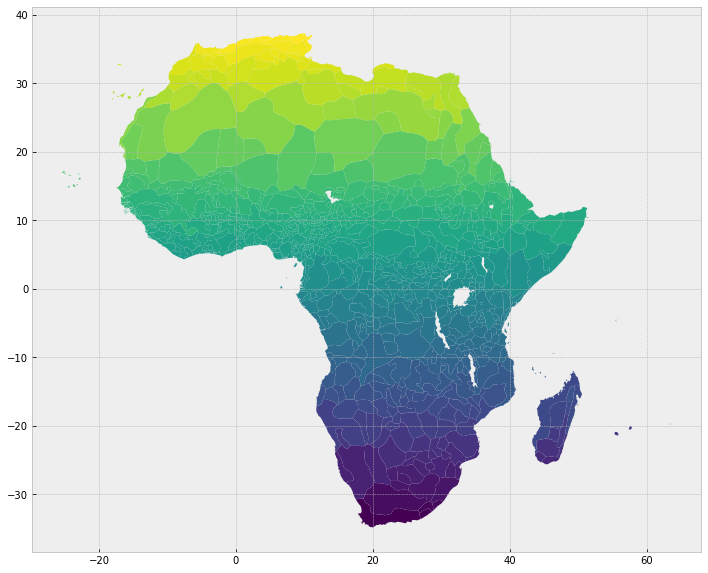

In [3]:
tribe_areas.plot(column='LAT', figsize=(12,16));

But this is a static map. For exploratory purposes it's nice to pass the geometry information from the geodataframe to ipyleaflet to map things on top of a slippy basemap.  We can specify what happens on cursor hover, coloring, etc. 

The map is an ipython 'widget' which means that as we add layers and other features the map will update to reflect those changes.

First, we just create a topographic basemap, centered around a location at the Center of Congo.

In [4]:
m = ilf.Map(center = [-4.0383, 21.7587], 
            zoom = 3.5)
m

Map(center=[-4.0383, 21.7587], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

We will load the dataframe into an ipyleaflet GeoData object that we will then add as a layer to the map.

In [5]:
tribes_data = ilf.GeoData(geo_dataframe = tribe_areas,style={ 'weight':1},
                          hover_style={'fillColor': 'green' , 'fillOpacity': 0.2, 'weight':5},
                          name = 'Tribes')
m.add_layer(tribes_data)

Next add an option to view things full-screen

In [6]:
m.add_control(ilf.FullScreenControl())
control = ilf.LayersControl(position='topright')
m.add_control(control)

And now a marker for each of the ethnographic regions identified on the map such that when we hover over the icon we see the name of the region.  Since there are hundreds of regions we'll also use the 'MarkerCluster' object so that the map is not overwhelmed with marker icons. When we zoom out we'll see just a cluster with a number indicating how many markers lie within the cluster.  The individual markers then become visible as we zoom in. 

In [7]:
m.add_layer(ilf.MarkerCluster(
                markers=[ilf.Marker(location=(row.LAT, row.LON), title=row.NAME) for i, row in tribe_areas.iterrows()])
          )

We can save it to a standalone HTML page that will remain interactive.

In [8]:
m.save('tribes.html', title='Afica Ethnologue Atlas')

**NOTE**: If the maps above are not visible in the static view of this notebook (as you might see on github). See this [saved HTML rendering](https://cdn.rawgit.com/jhconning/land_uct_2018/cbc64c77/notebooks/tribes.html) (which should be interactive)

## Raster data, zonal statistics

We want to calculate zonal statistics (in this case statistics for data that falls inside the ethnic group boundaries).  Here we'll get data on wheat yield potential which comes as raster data from FAO-GAEZ. Each gridpoint on the raster is associated with a suitability index.  We'll [plot](https://rasterio.readthedocs.io/en/latest/topics/plotting.html) and then calculate mean suitability in each of the polygons associated with Murdock/Nunn data.

In [9]:
import rasterio
import rasterstats as rs

In [10]:
import matplotlib.pyplot as plt

Get first downloaded raster data on potential crop yields from FAO-GAEZ data.  Looks like this. 

In [11]:
!dir *.tif

 Volume in drive C is Windows
 Volume Serial Number is A040-41A7

 Directory of C:\Users\jconn\Google Drive\GC\land\land_uct_2019\notebooks

02/13/18  04:45 PM         3,729,147 res02_crav6190h_whea000a_yld.tif
06/20/21  10:52 PM         1,873,865 sxHr_rcd.tif
               2 File(s)      5,603,012 bytes
               0 Dir(s)  152,246,722,560 bytes free


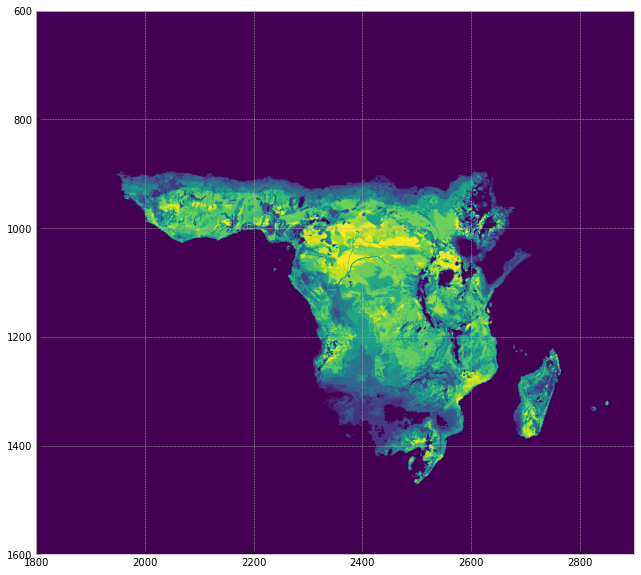

In [12]:
#wheat_tif = "res02_crav6190h_whea000a_yld.tif"
wheat_tif = "sxHr_rcd.tif"
wheat = rasterio.open(wheat_tif)
plt.figure(figsize=(12,10))
plt.xlim(1800,2900)
plt.ylim(1600,600)
plt.imshow(wheat.read(1));

Next we use the `rasterstats.zonal_stats` command to calculate 'count', 'max', 'min', 'mean' statistics for the raster data inside each polygon. The function returns the results as a python dictionary.

In [13]:
stats = rs.zonal_stats('borders_tribes.shp', wheat_tif, prefix = 'wheat_')

Finally let us add these calculated statistics as columns to our geodataframe.

In [14]:
colnames = pd.DataFrame(stats).columns.tolist()
colnames

['wheat_min', 'wheat_max', 'wheat_mean', 'wheat_count']

In [15]:
tribe_areas[colnames] = pd.DataFrame(stats)
tribe_areas.head()

,NAME,TRIBE_CODE,LAT,LON,geometry,wheat_min,wheat_max,wheat_mean,wheat_count
0,ABABDA,1,23.161800,33.70160,"POLYGON ((35.73971 22.87611, 35.54412 22.64326...",0.0,0.0,0.000000,1988
1,ABARAMBO,2,3.702955,26.79730,"POLYGON ((26.45080 3.39284, 26.45227 3.39798, ...",6483.0,9999.0,8315.512195,82
2,ABE,3,6.069531,-4.26032,"POLYGON ((-4.07477 6.37522, -4.01895 6.26358, ...",6956.0,8477.0,7587.083333,48
3,ACHOLI,4,3.108121,32.65680,"POLYGON ((33.25900 3.88539, 33.45547 3.86574, ...",1685.0,10000.0,7352.517241,319
4,ADAMAWA,5,7.556091,13.18470,"POLYGON ((14.14605 9.96943, 14.14605 9.87880, ...",0.0,10000.0,6061.716129,620


Let's see a simple chloropeth plot based on mean wheat potential in each ethnic group zone.

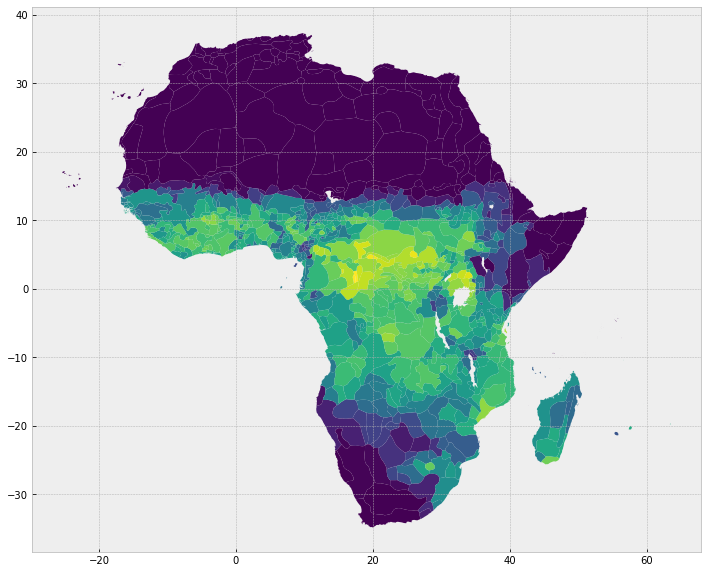

In [16]:
tribe_areas.plot(column='wheat_mean', figsize=(12,16));